# 1Hop True and False Questions

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import string
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# Load the CSV file
df = pd.read_csv('data/1hop_true_and_false.csv')  # Replace with your actual CSV file path

# Verify the number of rows
print(f"Loaded {len(df)} questions")

Loaded 500 questions


In [3]:
# Compare errors between with-context and without-context approaches
print("\nError Analysis:")
print("-" * 80)
print(f"{'Question':50} | {'Ground Truth':12} | {'With Context':12} | {'Without Context':15} | {'Notes'}") 
print("-" * 80)

for i, row in df.iterrows():
    # Check if either prediction is incorrect
    with_context_correct = row['with_context_parsed'] == row['answer'] if row['with_context_parsed'] is not None else False
    without_context_correct = row['without_context_parsed'] == row['answer'] if row['without_context_parsed'] is not None else False
    
    # Only show questions where at least one approach was incorrect
    if not (with_context_correct and without_context_correct):
        question = row['question'][:47] + "..." if len(row['question']) > 50 else row['question'].ljust(50)
        ground_truth = str(row['answer']).ljust(12)
        with_context = str(row['with_context_parsed']).ljust(12)
        without_context = str(row['without_context_parsed']).ljust(15)
        
        # Determine notes
        if with_context_correct and not without_context_correct:
            notes = "Context helped"
        elif not with_context_correct and without_context_correct:
            notes = "Context misled"
        else:
            notes = "Both incorrect"
            
        print(f"{question} | {ground_truth} | {with_context} | {without_context} | {notes}")


Error Analysis:
--------------------------------------------------------------------------------
Question                                           | Ground Truth | With Context | Without Context | Notes
--------------------------------------------------------------------------------
Can dry AMD lead to complete blindness?            | False        | True         | False           | Context misled
Does wet AMD progress faster than dry AMD?         | True         | True         | False           | Context helped
Does AMD affect peripheral vision more than cen... | False        | True         | False           | Context misled
Can AMD be diagnosed with a blood test?            | False        | True         | False           | Context misled
Is dry AMD more common than wet AMD?               | True         | True         | False           | Context helped
Are drusen deposits associated with dry AMD?       | True         | True         | False           | Context helped
Does AMD primarily

In [4]:
# Function to calculate metrics for a given set of predictions
def calculate_metrics(references, predictions, model_name):
    metrics = {}
    
    # Filter out None or NaN values
    valid_mask = ~pd.isna(predictions) & ~pd.isna(references)
    valid_refs = references[valid_mask].astype(str).str.lower()
    valid_preds = predictions[valid_mask].astype(str).str.lower()
    
    if len(valid_preds) > 0:
        metrics['accuracy'] = accuracy_score(valid_refs, valid_preds)
        metrics['precision'] = precision_score(valid_refs, valid_preds, pos_label='true', average='binary')
        metrics['recall'] = recall_score(valid_refs, valid_preds, pos_label='true', average='binary')
        metrics['f1'] = f1_score(valid_refs, valid_preds, pos_label='true', average='binary')
        metrics['confusion_matrix'] = confusion_matrix(valid_refs, valid_preds, labels=['true', 'false'])
        
        # Print evaluation results
        print(f"\n{model_name} - Evaluation Metrics:")
        print(f"Accuracy: {metrics['accuracy']:.2f} ({metrics['accuracy'] * 100:.1f}%)")
        print(f"Precision: {metrics['precision']:.2f}")
        print(f"Recall: {metrics['recall']:.2f}")
        print(f"F1-Score: {metrics['f1']:.2f}")
        print(f"Confusion Matrix (True/False):\n{metrics['confusion_matrix']}")
    else:
        print(f"No valid predictions to evaluate for {model_name}")
    
    return metrics

# Calculate metrics for without-context (simple model)
simple_metrics = calculate_metrics(df['answer'], df['without_context_parsed'], "Simple Model (Without Context)")

# Calculate metrics for with-context (RAG model)
rag_metrics = calculate_metrics(df['answer'], df['with_context_parsed'], "RAG Model (With Context)")


Simple Model (Without Context) - Evaluation Metrics:
Accuracy: 0.74 (73.9%)
Precision: 0.82
Recall: 0.66
F1-Score: 0.73
Confusion Matrix (True/False):
[[177  91]
 [ 39 191]]

RAG Model (With Context) - Evaluation Metrics:
Accuracy: 0.81 (80.6%)
Precision: 0.80
Recall: 0.86
F1-Score: 0.83
Confusion Matrix (True/False):
[[231  39]
 [ 58 172]]


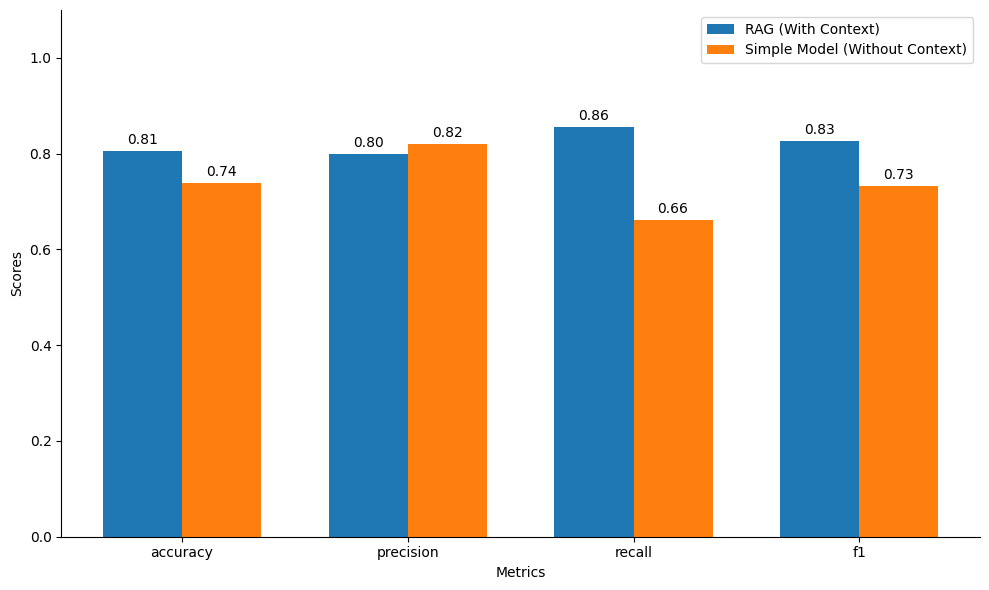

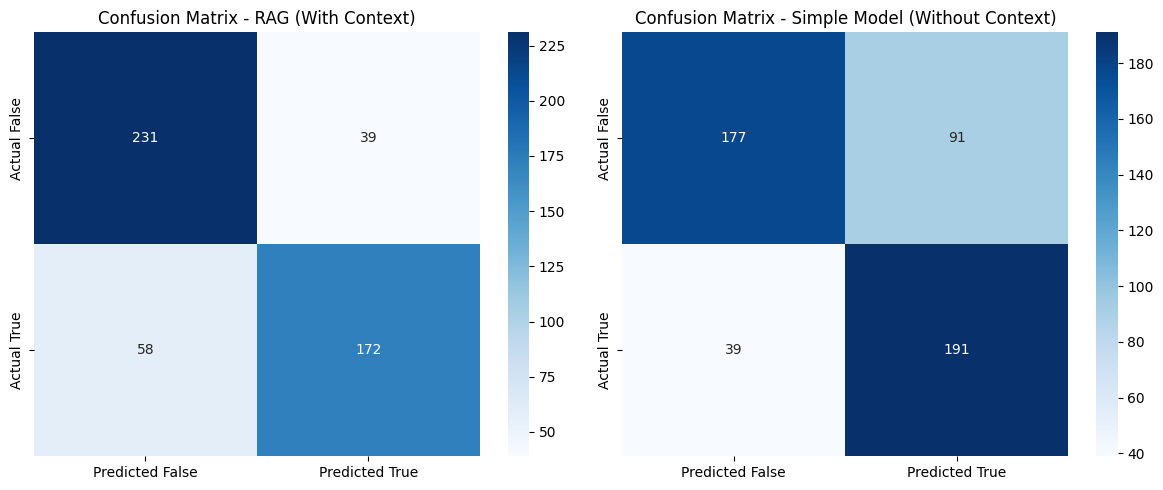

In [5]:
if rag_metrics and simple_metrics:
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    rag_values = [rag_metrics[m] for m in metrics]
    simple_values = [simple_metrics[m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, rag_values, width, label='RAG (With Context)', color='#1f77b4')
    rects2 = ax.bar(x + width/2, simple_values, width, label='Simple Model (Without Context)', color='#ff7f0e')
    
    # Add labels
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim(0, 1.1)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add value labels
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    add_labels(rects1)
    add_labels(rects2)
    
    plt.tight_layout()
    plt.savefig('metrics_comparison.png')  # Save the plot
    
    # Visualize confusion matrices (unchanged)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # RAG confusion matrix
    sns.heatmap(rag_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Predicted False', 'Predicted True'],
                yticklabels=['Actual False', 'Actual True'])
    ax1.set_title('Confusion Matrix - RAG (With Context)')
    
    # Simple model confusion matrix
    sns.heatmap(simple_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax2,
                xticklabels=['Predicted False', 'Predicted True'],
                yticklabels=['Actual False', 'Actual True'])
    ax2.set_title('Confusion Matrix - Simple Model (Without Context)')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png')  # Save the plot
else:
    print("Not enough data to visualize comparison")

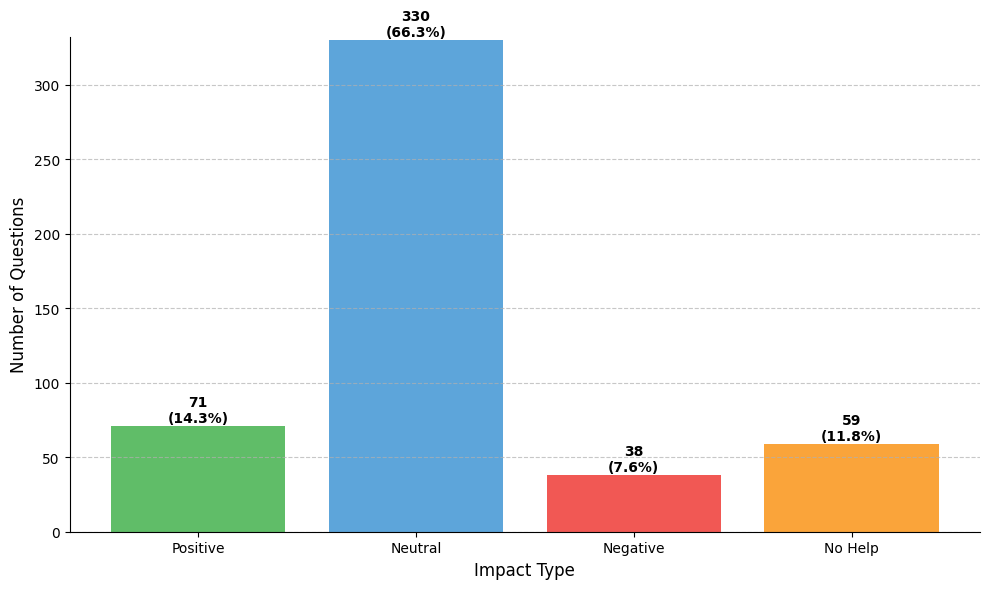

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Recompute context_impact
df['context_impact_computed'] = None

for i, row in df.iterrows():
    # Skip if either prediction or answer is None or NaN
    if pd.isna(row['with_context_parsed']) or pd.isna(row['without_context_parsed']) or pd.isna(row['answer']):
        df.at[i, 'context_impact_computed'] = 'Unknown'
        continue
    
    # Convert to lowercase strings for consistent comparison
    with_context = str(row['with_context_parsed']).lower()
    without_context = str(row['without_context_parsed']).lower()
    answer = str(row['answer']).lower()
    
    with_correct = with_context == answer
    without_correct = without_context == answer
    
    if with_correct and not without_correct:
        df.at[i, 'context_impact_computed'] = 'Positive'
    elif not with_correct and without_correct:
        df.at[i, 'context_impact_computed'] = 'Negative'
    elif with_correct and without_correct:
        df.at[i, 'context_impact_computed'] = 'Neutral'
    else:  # both incorrect
        df.at[i, 'context_impact_computed'] = 'No Help'

# Summarize context impact
impact_counts = df['context_impact_computed'].value_counts()
unknown_count = impact_counts.get('Unknown', 0)

# Define the order and colors for consistency
impact_order = ['Positive', 'Neutral', 'Negative', 'No Help']
impact_colors = {
    'Positive': '#60BD68',  # Green
    'Neutral': '#5DA5DA',   # Blue
    'Negative': '#F15854',  # Red
    'No Help': '#FAA43A',   # Orange
}

# Get counts for known impacts
ordered_counts = [impact_counts.get(impact, 0) for impact in impact_order]
total_known = sum(ordered_counts)

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(impact_order, ordered_counts, color=[impact_colors[impact] for impact in impact_order])
plt.xlabel('Impact Type', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count and percentage labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = (height / total_known * 100) if total_known > 0 else 0
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

# Get current axes and hide the top and right spines, and remove their ticks
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(top=False, right=False)

# Adjust y-axis limit to ensure labels fit
max_height = max(ordered_counts)
plt.ylim(0, max_height + 2)  # Adds padding above the tallest bar

plt.tight_layout()
plt.savefig('context_impact_distribution.png')  # Save the plot
plt.show()